Total clips for userId=6: 297
Categories: ['การออกกำลังกาย' 'สปอย' 'พอดแคสต์พัฒนาตนเอง' 'สารคดี' 'ข่าว']


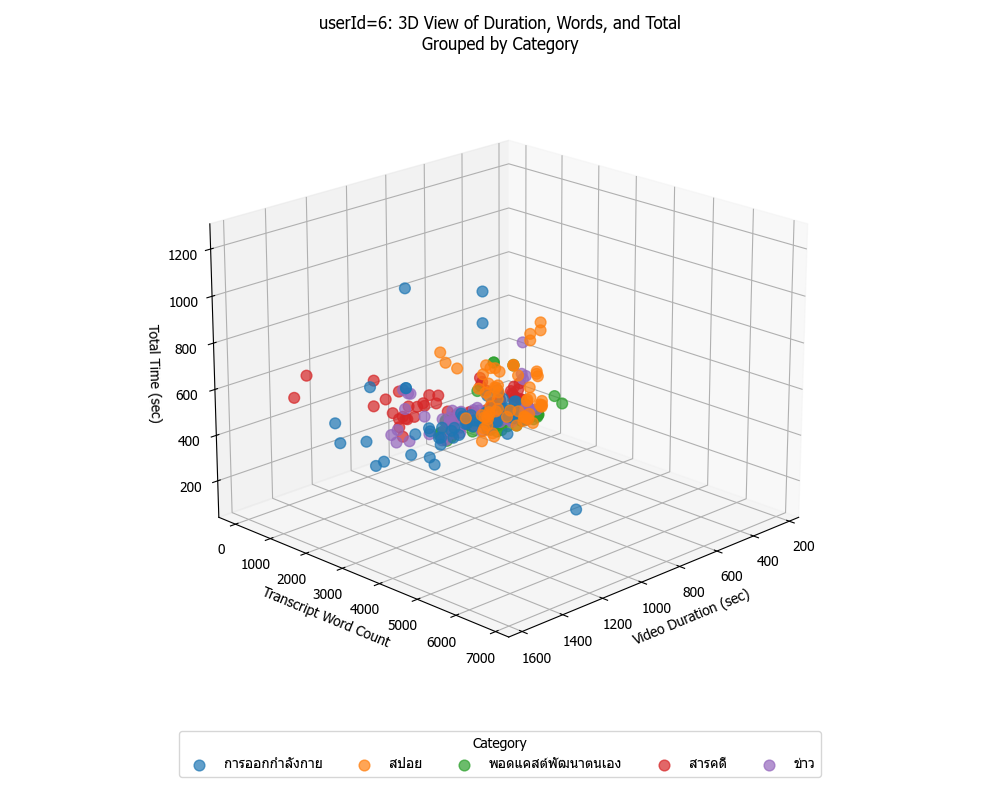

In [6]:
%matplotlib widget
# =========================
# ANALYSIS: userId = 6
# 3D Scatter Plot: transcriptWord, durationSec, timeTotal
# =========================
import pandas as pd
import matplotlib.pyplot as plt
import re
from mpl_toolkits.mplot3d import Axes3D

# ตั้งค่าฟอนต์ภาษาไทย
plt.rcParams['font.family'] = 'Tahoma'

# --- Load Data ---
stats_df = pd.read_csv('stats_data.csv')
mapper_df = pd.read_excel('75clip_mapper.xlsx')

userId = 6

# --- Filter userId = 6 and status = DONE ---
df_user6 = stats_df[(stats_df['userId'] == userId) & (stats_df['status'] == 'DONE')].copy()

# --- Normalize YouTube URL for joining ---
def normalize_url(url):
    if pd.isna(url):
        return None
    patterns = [
        r'(?:v=|youtu\.be/)([a-zA-Z0-9_-]{11})',
        r'(?:embed/)([a-zA-Z0-9_-]{11})',
        r'(?:shorts/)([a-zA-Z0-9_-]{11})'
    ]
    for pattern in patterns:
        match = re.search(pattern, str(url))
        if match:
            return match.group(1)
    return None

df_user6['video_id'] = df_user6['youtubeUrl'].apply(normalize_url)
mapper_df['video_id'] = mapper_df['YoutubeUrl'].apply(normalize_url)

# --- Merge with mapper ---
df_merged = df_user6.merge(
    mapper_df[['video_id', 'Category', 'Duration(min)']],
    on='video_id',
    how='left'
)

# --- Filter valid data ---
df_merged = df_merged.dropna(subset=['transcriptWord', 'durationSec', 'timeTotal', 'Category'])

print(f'Total clips for userId=6: {len(df_merged)}')
print(f'Categories: {df_merged["Category"].unique()}')

# =========================
# 3D SCATTER PLOT (แก้ไขแล้ว)
# =========================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

categories = df_merged['Category'].unique()
colors = plt.cm.tab10(range(len(categories)))

for i, cat in enumerate(categories):
    subset = df_merged[df_merged['Category'] == cat]
    ax.scatter(
        subset['durationSec'],
        subset['transcriptWord'],
        subset['timeTotal'],
        c=[colors[i]],
        label=cat,
        alpha=0.7,
        s=60
    )

ax.set_xlabel('Video Duration (sec)')
ax.set_ylabel('Transcript Word Count')
ax.set_zlabel('Total Time (sec)')
ax.set_title('userId=6: 3D View of Duration, Words, and Total\nGrouped by Category')

# ย้าย legend ออกไปด้านล่าง
fig.legend(title='Category', loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0.02))

# ปรับมุมมองให้เห็นแกน z ชัดขึ้น
ax.view_init(elev=20, azim=45)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # เว้นที่ด้านล่างสำหรับ legend
plt.show()

In [4]:
import plotly.express as px

# สร้าง 2D Scatter Plot แบบ interactive
fig = px.scatter(
    df_merged,
    x='durationSec',
    y='timeTotal',
    color='Category',
    hover_data=['transcriptWord', 'whisperTemp', 'youtubeUrl'],  # เพิ่ม whisperTemp
    title='userId=6: Video Duration vs Total Time<br>(Hover to see Transcript Word Count)',
    labels={
        'durationSec': 'ความยาวคลิป (sec)',
        'timeTotal': 'เวลาที่ใช้สรุปทั้งหมด (sec)',
        'transcriptWord': 'จำนวนคำ',
        'whisperTemp': 'Whisper Temp'  
    }
)

# ปรับขนาดและ style
fig.update_traces(marker=dict(size=10, opacity=0.7))
fig.update_layout(
    width=900,
    height=600,
    legend_title_text='Category',
    hovermode='closest'
)

fig.show()

### 1.filter by category, whisperTemp, duration (100group) อยากรู้ว่า ยิ่ง transcript word มาก มันส่งผลต่อ total time ไหม

In [ ]:
คิด trend โดย sort x เช่น(1, 3, 5) แล้วดูว่า ค่า มีส่วนต่าง(y2 - y1, y3 - y2)เท่าไร ถ้าเป็น + คู่ = increadsing 
ถ้าเป็น - คู่ = decreasing

In [4]:
df_merged["duration_group"] = (df_merged["durationSec"] / 300).round() * 300
import numpy as np

def trend_direction(x, y):
    # x = transcriptWord, y = totalTime
    order = np.argsort(x)
    y_sorted = y[order]

    if np.all(np.diff(y_sorted) > 0):
        return "increasing"
    elif np.all(np.diff(y_sorted) < 0):
        return "decreasing"
    else:
        return "mixed"

results = []

group_cols = ["Category", "whisperTemp", "duration_group"]

for keys, g in df_merged.groupby(group_cols):
    if len(g) == 3:
        trend = trend_direction(
            g["transcriptWord"].values,
            g["timeTotal"].values
        )
        results.append({
            "Category": keys[0],
            "Temp": keys[1],
            "Duration": keys[2],
            "trend": trend
        })

import pandas as pd

trend_df = pd.DataFrame(results)

trend_df.groupby(["Category", "Temp"])["trend"].value_counts(normalize=True)

import plotly.express as px

summary = (
    trend_df
    .assign(is_increasing=lambda x: x["trend"] == "increasing")
    .groupby(["Category", "Temp"])["is_increasing"]
    .mean()
    .reset_index()
)

fig = px.imshow(
    summary.pivot(
        index="Category",
        columns="Temp",
        values="is_increasing"
    ),
    title="Proportion of Groups Showing Increasing Total Time<br>with Transcript Word Count",
    text_auto=True  # เพิ่มบรรทัดนี้เพื่อแสดงตัวเลข
)

fig.show()

ผล: word มาก ส่งผลให้เวลาเพิ่มจะเป็นจริงแค่ พอสแคสต์ แต่ category พบว่าไม่จำเป็นเสมอไป หรือไม่ก็ ข้อมูลไม่เพียงพอ

### งั้นลองเปลี่ยนจาก total time -> speech to text time

In [8]:
# 1) สร้าง duration group (5,10,15,20,25 นาที)
df_merged["duration_group"] = (df_merged["durationSec"] / 300).round() * 300

import numpy as np

# 2) ฟังก์ชันดูแนวโน้ม (เหมือนเดิม)
def trend_direction(x, y):
    # x = transcriptWord, y = timeSpeechtoTextSec
    order = np.argsort(x)
    y_sorted = y[order]

    if np.all(np.diff(y_sorted) > 0):
        return "increasing"
    elif np.all(np.diff(y_sorted) < 0):
        return "decreasing"
    else:
        return "mixed"

# 3) คำนวณ trend ต่อ group
results = []

group_cols = ["Category", "whisperTemp", "duration_group"]

for keys, g in df_merged.groupby(group_cols):
    # ต้องมีครบ 3 ตัว และ STT time ไม่เป็น NaN
    if len(g) == 3 and g["timeSpeechtoTextSec"].notna().all():
        trend = trend_direction(
            g["transcriptWord"].values,
            g["timeSpeechtoTextSec"].values
        )
        results.append({
            "Category": keys[0],
            "Temp": keys[1],
            "Duration": keys[2],
            "trend": trend
        })

import pandas as pd

trend_df = pd.DataFrame(results)

# 4) ดูสัดส่วน trend (optional debug)
trend_df.groupby(["Category", "Temp"])["trend"].value_counts(normalize=True)
import plotly.express as px

summary = (
    trend_df
    .assign(is_increasing=lambda x: x["trend"] == "increasing")
    .groupby(["Category", "Temp"])["is_increasing"]
    .mean()
    .reset_index()
)

fig = px.imshow(
    summary.pivot(
        index="Category",
        columns="Temp",
        values="is_increasing"
    ),
    title="Proportion of Groups Showing Increasing STT Time<br>with Transcript Word Count"
)

fig.show()


ผล: มีแนวโน้มว่า ยิ่ง transcriptWord มากขึ้น ยิ่ง timeSpeechtoTextSec มากขึ้นตาม ในหลายกลุ่ม

In [8]:
# คำนวณ delta (เปลี่ยนแปลง) ภายในแต่ละ duration group
delta_results = []

for keys, g in df_merged.groupby(group_cols):
    if len(g) >= 2:
        g_sorted = g.sort_values("transcriptWord")
        
        # หา delta ระหว่าง min word กับ max word
        word_min = g_sorted["transcriptWord"].iloc[0]
        word_max = g_sorted["transcriptWord"].iloc[-1]
        time_min = g_sorted["timeTotal"].iloc[0]
        time_max = g_sorted["timeTotal"].iloc[-1]
        
        delta_word = word_max - word_min
        delta_time = time_max - time_min
        
        if delta_word > 0:
            time_per_word = delta_time / delta_word
        else:
            time_per_word = np.nan
        
        delta_results.append({
            "Category": keys[0],
            "Temp": keys[1],
            "Duration": keys[2],
            "Δword": delta_word,
            "Δtime": delta_time,
            "sec_per_word": time_per_word
        })

delta_df = pd.DataFrame(delta_results)
print(delta_df)

# สรุป
print("\n=== เฉลี่ย: เวลาที่เพิ่มต่อ 1 word (วินาที) ===")
summary_delta = delta_df.groupby(["Category", "Temp"])["sec_per_word"].agg(["mean", "std", "count"])
print(summary_delta)

# Heatmap
pivot_delta = (
    delta_df
    .groupby(["Category", "Temp"])["sec_per_word"]
    .mean()
    .reset_index()
    .pivot(index="Category", columns="Temp", values="sec_per_word")
)

fig = px.imshow(
    pivot_delta,
    title="เวลาที่เพิ่มขึ้นต่อ 1 word (วินาที)<br>คำนวณจาก Δtime / Δword ในแต่ละ duration group",
    text_auto=".4f",
    color_continuous_scale="RdYlGn_r"
)
fig.show()

          Category  Temp  Duration   Δword   Δtime  sec_per_word
0   การออกกำลังกาย   0.0     300.0   438.0  -35.85     -0.081849
1   การออกกำลังกาย   0.0     600.0   272.0   64.33      0.236507
2   การออกกำลังกาย   0.0     900.0  1670.0  177.14      0.106072
3   การออกกำลังกาย   0.0    1200.0  1501.0   69.54      0.046329
4   การออกกำลังกาย   0.0    1500.0  1699.0  116.48      0.068558
..             ...   ...       ...     ...     ...           ...
95          สารคดี   0.6     300.0   455.0    4.61      0.010132
96          สารคดี   0.6     600.0   400.0   72.97      0.182425
97          สารคดี   0.6     900.0  1057.0  261.49      0.247389
98          สารคดี   0.6    1200.0   345.0  146.37      0.424261
99          สารคดี   0.6    1500.0   450.0  -73.86     -0.164133

[100 rows x 6 columns]

=== เฉลี่ย: เวลาที่เพิ่มต่อ 1 word (วินาที) ===
                             mean       std  count
Category           Temp                           
การออกกำลังกาย     0.0   0.075123  0.114581  

In [10]:
# คำนวณ delta (เปลี่ยนแปลง) ภายในแต่ละ duration group
delta_results = []

for keys, g in df_merged.groupby(group_cols):
    if len(g) >= 2:
        g_sorted = g.sort_values("transcriptWord")
        
        # หา delta ระหว่าง min word กับ max word
        word_min = g_sorted["transcriptWord"].iloc[0]
        word_max = g_sorted["transcriptWord"].iloc[-1]
        time_min = g_sorted["timeSpeechtoTextSec"].iloc[0]
        time_max = g_sorted["timeSpeechtoTextSec"].iloc[-1]
        
        delta_word = word_max - word_min
        delta_time = time_max - time_min
        
        if delta_word > 0:
            time_per_word = delta_time / delta_word
        else:
            time_per_word = np.nan
        
        delta_results.append({
            "Category": keys[0],
            "Temp": keys[1],
            "Duration": keys[2],
            "Δword": delta_word,
            "Δtime": delta_time,
            "sec_per_word": time_per_word
        })

delta_df = pd.DataFrame(delta_results)
print(delta_df)

# สรุป
print("\n=== เฉลี่ย: เวลาที่เพิ่มต่อ 1 word (วินาที) ===")
summary_delta = delta_df.groupby(["Category", "Temp"])["sec_per_word"].agg(["mean", "std", "count"])
print(summary_delta)

# Heatmap
pivot_delta = (
    delta_df
    .groupby(["Category", "Temp"])["sec_per_word"]
    .mean()
    .reset_index()
    .pivot(index="Category", columns="Temp", values="sec_per_word")
)

fig = px.imshow(
    pivot_delta,
    title="เวลาที่เพิ่มขึ้นต่อ 1 word (วินาที)<br>คำนวณจาก Δtime / Δword ในแต่ละ duration group",
    text_auto=".4f",
    color_continuous_scale="RdYlGn_r"
)
fig.show()

          Category  Temp  Duration   Δword   Δtime  sec_per_word
0   การออกกำลังกาย   0.0     300.0   438.0   -7.90     -0.018037
1   การออกกำลังกาย   0.0     600.0   272.0   41.72      0.153382
2   การออกกำลังกาย   0.0     900.0  1670.0  132.60      0.079401
3   การออกกำลังกาย   0.0    1200.0  1501.0 -124.45     -0.082911
4   การออกกำลังกาย   0.0    1500.0  1699.0   89.94      0.052937
..             ...   ...       ...     ...     ...           ...
95          สารคดี   0.6     300.0   455.0   32.10      0.070549
96          สารคดี   0.6     600.0   400.0   44.56      0.111400
97          สารคดี   0.6     900.0  1057.0  128.97      0.122015
98          สารคดี   0.6    1200.0   345.0   28.62      0.082957
99          สารคดี   0.6    1500.0   450.0   46.52      0.103378

[100 rows x 6 columns]

=== เฉลี่ย: เวลาที่เพิ่มต่อ 1 word (วินาที) ===
                             mean       std  count
Category           Temp                           
การออกกำลังกาย     0.0   0.036955  0.090836  

### 2.whisper temp มากๆ มันทำให้สรุปเร็วขึ้นหรอ

=== Average STT Time by Category, Temp, Duration ===
          Category  whisperTemp  duration_group  avg_stt_time
0   การออกกำลังกาย          0.0             300     99.473333
1   การออกกำลังกาย          0.0             600    169.813333
2   การออกกำลังกาย          0.0             900    315.423333
3   การออกกำลังกาย          0.0            1200    695.442500
4   การออกกำลังกาย          0.0            1500    599.118000
5   การออกกำลังกาย          0.2             300    100.756667
6   การออกกำลังกาย          0.2             600    185.413333
7   การออกกำลังกาย          0.2             900    354.090000
8   การออกกำลังกาย          0.2            1200    420.380000
9   การออกกำลังกาย          0.2            1500    506.503333
10  การออกกำลังกาย          0.4             300    138.543333
11  การออกกำลังกาย          0.4             600    217.566667
12  การออกกำลังกาย          0.4             900    324.260000
13  การออกกำลังกาย          0.4            1200    455.923333
14  การออกกำลังกา

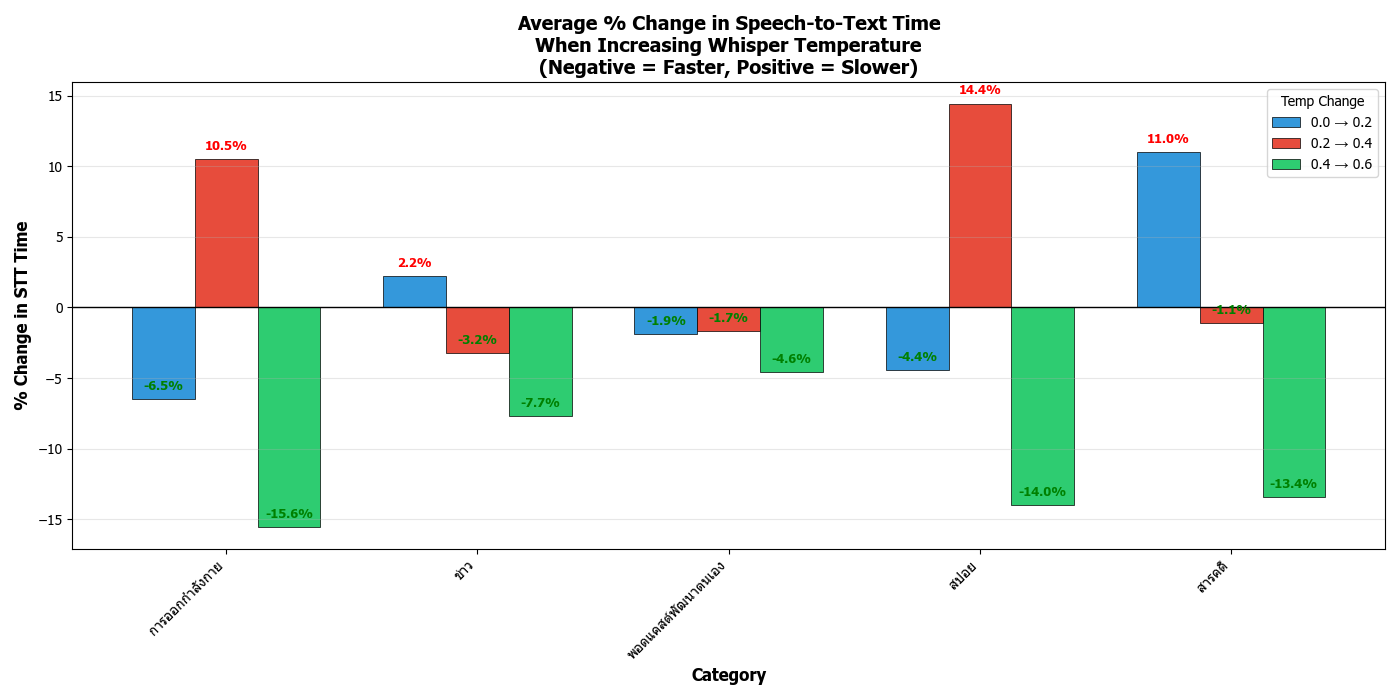


SUMMARY: Average % Change in STT Time by Category & Temp Change
Temp Change         0.0 → 0.2  0.2 → 0.4  0.4 → 0.6
Category                                           
การออกกำลังกาย          -6.46      10.54     -15.57
ข่าว                     2.19      -3.24      -7.71
พอดแคสต์พัฒนาตนเอง      -1.89      -1.66      -4.60
สปอย                    -4.44      14.44     -14.01
สารคดี                  10.97      -1.12     -13.41

* Negative values = STT time decreased (faster)
* Positive values = STT time increased (slower)


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: คำนวณค่าเฉลี่ย timeSpeechtoTextSec แยกตาม Category, whisperTemp, duration_group
avg_stt = (
    df
    .groupby(["Category", "whisperTemp", "duration_group"])["timeSpeechtoTextSec"]
    .mean()
    .reset_index()
    .rename(columns={"timeSpeechtoTextSec": "avg_stt_time"})
)

print("=== Average STT Time by Category, Temp, Duration ===")
print(avg_stt.head(20))

# Step 2: คำนวณ % change เมื่อ temp เพิ่มขึ้น
temp_pairs = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6)]

pct_change_results = []

for cat in df["Category"].unique():
    for dur in df["duration_group"].unique():
        subset = avg_stt[(avg_stt["Category"] == cat) & (avg_stt["duration_group"] == dur)]
        
        for temp_from, temp_to in temp_pairs:
            time_from = subset[subset["whisperTemp"] == temp_from]["avg_stt_time"].values
            time_to = subset[subset["whisperTemp"] == temp_to]["avg_stt_time"].values
            
            if len(time_from) > 0 and len(time_to) > 0:
                pct_change = ((time_to[0] - time_from[0]) / time_from[0]) * 100
                pct_change_results.append({
                    "Category": cat,
                    "Duration": dur,
                    "temp_change": f"{temp_from} → {temp_to}",
                    "pct_change": pct_change  # ค่าลบ = ลดลง, ค่าบวก = เพิ่มขึ้น
                })

pct_df = pd.DataFrame(pct_change_results)
print("\n=== % Change in STT Time (per Duration) ===")
print(pct_df.head(20))

# Step 3: เฉลี่ย % change ทุก duration แยกตาม Category และ temp_change
summary_pct = (
    pct_df
    .groupby(["Category", "temp_change"])["pct_change"]
    .agg(["mean", "std", "count"])
    .reset_index()
    .rename(columns={"mean": "avg_pct_change", "std": "std_pct_change", "count": "n_durations"})
)

print("\n=== Average % Change (across all durations) ===")
print(summary_pct)

# Step 4: Visualization - Grouped Bar Chart
fig, ax = plt.subplots(figsize=(14, 7))

# Pivot for plotting
pivot_data = summary_pct.pivot(index="Category", columns="temp_change", values="avg_pct_change")

# Ensure correct order of temp changes
temp_order = ["0.0 → 0.2", "0.2 → 0.4", "0.4 → 0.6"]
pivot_data = pivot_data[temp_order]

# Get 5 categories
categories = pivot_data.index.tolist()[:5]
pivot_data = pivot_data.loc[categories]

# Bar positions
x = np.arange(len(categories))
width = 0.25

# Colors
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Plot bars
for i, (temp_change, color) in enumerate(zip(temp_order, colors)):
    values = pivot_data[temp_change].values
    bars = ax.bar(x + i * width, values, width, label=temp_change, color=color, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for bar, val in zip(bars, values):
        if not np.isnan(val):
            color_text = 'green' if val < 0 else 'red'
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold', color=color_text)

# Styling
ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('% Change in STT Time', fontsize=12, fontweight='bold')
ax.set_title('Average % Change in Speech-to-Text Time\nWhen Increasing Whisper Temperature\n(Negative = Faster, Positive = Slower)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.legend(title='Temp Change', loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('stt_time_pct_change.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary table
print("\n" + "="*60)
print("SUMMARY: Average % Change in STT Time by Category & Temp Change")
print("="*60)
pivot_display = pivot_data.round(2)
pivot_display.columns.name = "Temp Change"
print(pivot_display.to_string())
print("\n* Negative values = STT time decreased (faster)")
print("* Positive values = STT time increased (slower)")

## 3.Speech-to-Text  เป็น bottleneck จริงไหม Speech-to-Text ใช้สัดส่วนกี่ % ของ total time ในแต่ละ Category?

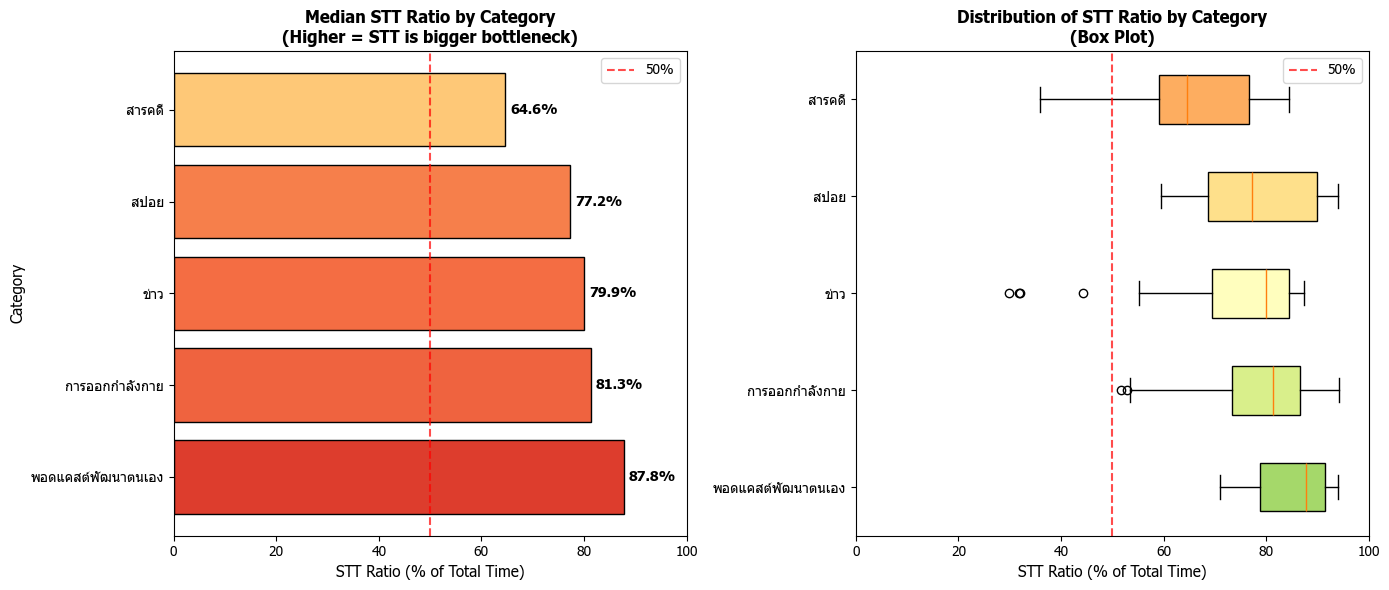

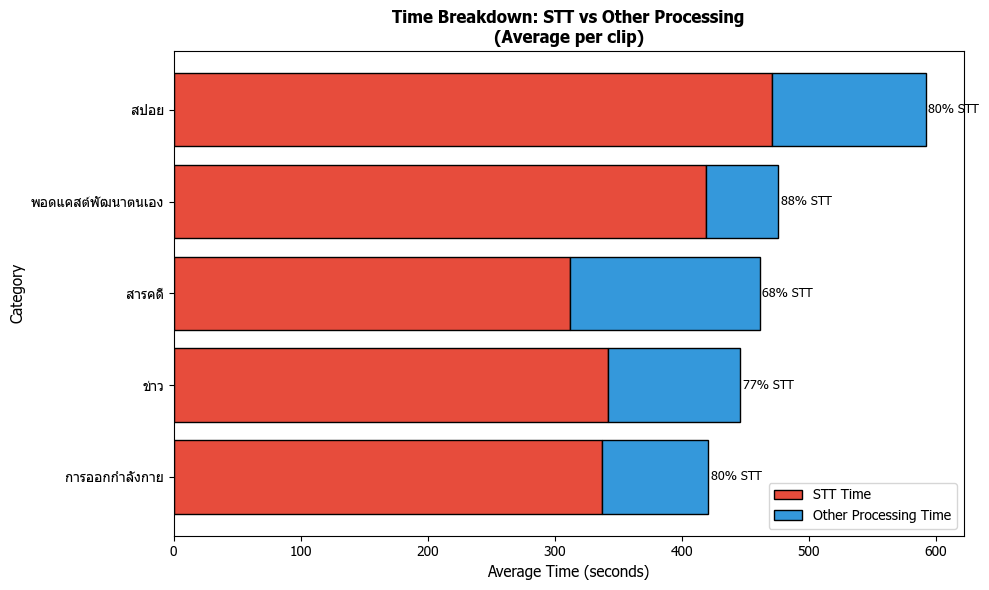


📊 STT Bottleneck Analysis Summary

Category                  Median %     Mean %       Count
-------------------------------------------------------
พอดแคสต์พัฒนาตนเอง            87.8%        85.5%       60
การออกกำลังกาย                81.3%        78.6%       61
ข่าว                          79.9%        74.8%       57
สปอย                          77.2%        78.3%       63
สารคดี                        64.6%        65.3%       56
-------------------------------------------------------
Overall                       78.9%

💡 Conclusion:
   STT คิดเป็น 78.9% ของเวลาทั้งหมด → STT เป็น bottleneck หลัก ✅


In [2]:
# ===========================================
# STT Bottleneck Analysis: สัดส่วนเวลา STT ต่อ Total Time
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# กำหนดฟอนต์ภาษาไทย
plt.rcParams['font.family'] = 'Tahoma'

# คำนวณ stt_ratio
df["stt_ratio"] = df["timeSpeechtoTextSec"] / df["timeTotal"]

# วิเคราะห์ตาม Category
stt_stats = df.groupby("Category")["stt_ratio"].agg(['median', 'mean', 'std', 'count'])
stt_stats = stt_stats.sort_values('median', ascending=False)

# ===========================================
# Visualization 1: Bar Chart - Median STT Ratio by Category
# ===========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Median STT Ratio
ax1 = axes[0]
colors = plt.cm.RdYlGn_r(stt_stats['median'].values)  # สีแดง = สัดส่วนสูง
bars = ax1.barh(stt_stats.index, stt_stats['median'] * 100, color=colors, edgecolor='black')
ax1.set_xlabel('STT Ratio (% of Total Time)', fontsize=11)
ax1.set_ylabel('Category', fontsize=11)
ax1.set_title('Median STT Ratio by Category\n(Higher = STT is bigger bottleneck)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 100)
ax1.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='50%')

# เพิ่มตัวเลขบน bar
for bar, val in zip(bars, stt_stats['median'] * 100):
    ax1.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
             va='center', fontsize=10, fontweight='bold')

ax1.legend()

# ===========================================
# Visualization 2: Box Plot - Distribution of STT Ratio
# ===========================================
ax2 = axes[1]
categories_sorted = stt_stats.index.tolist()
data_for_boxplot = [df[df['Category'] == cat]['stt_ratio'].values * 100 for cat in categories_sorted]

bp = ax2.boxplot(data_for_boxplot, vert=False, patch_artist=True)
ax2.set_yticklabels(categories_sorted)
ax2.set_xlabel('STT Ratio (% of Total Time)', fontsize=11)
ax2.set_title('Distribution of STT Ratio by Category\n(Box Plot)', fontsize=12, fontweight='bold')
ax2.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='50%')
ax2.set_xlim(0, 100)

# สีของ box plot
colors_bp = plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(categories_sorted)))
for patch, color in zip(bp['boxes'], colors_bp):
    patch.set_facecolor(color)

ax2.legend()

plt.tight_layout()
plt.savefig('stt_bottleneck_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# ===========================================
# Visualization 3: Stacked Bar - เวลา STT vs เวลาอื่นๆ
# ===========================================
fig2, ax3 = plt.subplots(figsize=(10, 6))

# คำนวณค่าเฉลี่ยเวลาสำหรับแต่ละ Category
time_breakdown = df.groupby("Category").agg({
    'timeSpeechtoTextSec': 'mean',
    'timeTotal': 'mean'
}).sort_values('timeTotal', ascending=True)

time_breakdown['other_time'] = time_breakdown['timeTotal'] - time_breakdown['timeSpeechtoTextSec']

# Stacked Bar
bars_stt = ax3.barh(time_breakdown.index, time_breakdown['timeSpeechtoTextSec'], 
                     label='STT Time', color='#e74c3c', edgecolor='black')
bars_other = ax3.barh(time_breakdown.index, time_breakdown['other_time'], 
                       left=time_breakdown['timeSpeechtoTextSec'],
                       label='Other Processing Time', color='#3498db', edgecolor='black')

ax3.set_xlabel('Average Time (seconds)', fontsize=11)
ax3.set_ylabel('Category', fontsize=11)
ax3.set_title('Time Breakdown: STT vs Other Processing\n(Average per clip)', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right')

# เพิ่ม % บน bar
for i, cat in enumerate(time_breakdown.index):
    stt_time = time_breakdown.loc[cat, 'timeSpeechtoTextSec']
    total_time = time_breakdown.loc[cat, 'timeTotal']
    ratio = stt_time / total_time * 100
    ax3.text(total_time + 2, i, f'{ratio:.0f}% STT', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('stt_time_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()

# ===========================================
# Print Summary
# ===========================================
print("\n" + "=" * 50)
print("📊 STT Bottleneck Analysis Summary")
print("=" * 50)
print(f"\n{'Category':<25} {'Median %':<12} {'Mean %':<12} {'Count'}")
print("-" * 55)
for cat in stt_stats.index:
    print(f"{cat:<25} {stt_stats.loc[cat, 'median']*100:>8.1f}%    {stt_stats.loc[cat, 'mean']*100:>8.1f}%    {int(stt_stats.loc[cat, 'count']):>5}")

overall_median = df['stt_ratio'].median() * 100
print("-" * 55)
print(f"{'Overall':<25} {overall_median:>8.1f}%")
print("\n💡 Conclusion:")
if overall_median > 50:
    print(f"   STT คิดเป็น {overall_median:.1f}% ของเวลาทั้งหมด → STT เป็น bottleneck หลัก ✅")
else:
    print(f"   STT คิดเป็น {overall_median:.1f}% ของเวลาทั้งหมด → STT ไม่ใช่ bottleneck หลัก")

## 4.temp สูง ทำให้เวลา “ผันผวน” มากขึ้นไหม

=== CV of STT Time per 1k Word (by Category, Temp, Duration) ===
          Category  whisperTemp  duration_group        mean         std  \
0   การออกกำลังกาย          0.0             300  182.670484   78.208093   
1   การออกกำลังกาย          0.0             600  165.129342   11.208473   
2   การออกกำลังกาย          0.0             900  133.029277   29.261054   
3   การออกกำลังกาย          0.0            1200  158.097506   78.121223   
4   การออกกำลังกาย          0.0            1500  150.401588   37.566583   
5   การออกกำลังกาย          0.2             300  215.364488   34.831930   
6   การออกกำลังกาย          0.2             600  157.065909   25.492533   
7   การออกกำลังกาย          0.2             900  162.932729   28.314332   
8   การออกกำลังกาย          0.2            1200  126.150504   14.032114   
9   การออกกำลังกาย          0.2            1500  159.167753   31.511164   
10  การออกกำลังกาย          0.4             300  255.851602   33.234373   
11  การออกกำลังกาย          0.4    

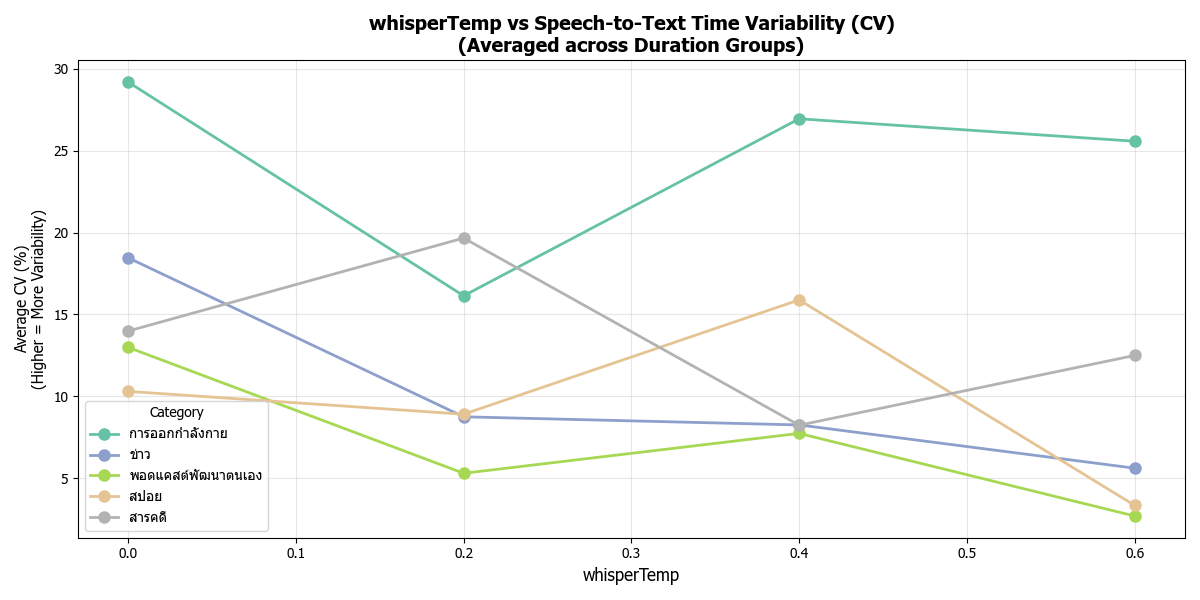


📊 Spearman: whisperTemp vs STT Time CV (ควบคุม Duration แล้ว)

Category                  rho        p-value    Result
-----------------------------------------------------------------
การออกกำลังกาย            -0.400     0.6000     ↑temp = ↓ผันผวน ✅
ข่าว                      -1.000     0.0000     ↑temp = ↓ผันผวน ✅
พอดแคสต์พัฒนาตนเอง        -0.800     0.2000     ↑temp = ↓ผันผวน ✅
สปอย                      -0.400     0.6000     ↑temp = ↓ผันผวน ✅
สารคดี                    -0.600     0.4000     ↑temp = ↓ผันผวน ✅


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

plt.rcParams['font.family'] = 'Tahoma'

df_clean = df[df['transcriptWord'] >= 100].copy()

# เปลี่ยนเป็นใช้ timeSpeechtoTextSec แทน timeTotal
df_clean["stt_time_per_1k_word"] = df_clean["timeSpeechtoTextSec"] / df_clean["transcriptWord"] * 1000

# คำนวณ CV ภายในแต่ละ (Category, whisperTemp, duration_group)
variability_by_dur = (
    df_clean
    .groupby(["Category", "whisperTemp", "duration_group"])["stt_time_per_1k_word"]  # ← เปลี่ยนตรงนี้
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

# คำนวณ CV สำหรับแต่ละ duration_group
variability_by_dur['cv'] = variability_by_dur['std'] / variability_by_dur['mean'] * 100

# กรองเฉพาะ group ที่มีข้อมูล >= 2 เพื่อให้ std มีความหมาย
variability_by_dur = variability_by_dur[variability_by_dur['count'] >= 2]

print("=== CV of STT Time per 1k Word (by Category, Temp, Duration) ===")
print(variability_by_dur.head(15))

# เฉลี่ย CV ข้าม duration_group
avg_cv = (
    variability_by_dur
    .groupby(["Category", "whisperTemp"])["cv"]
    .mean()
    .reset_index()
    .rename(columns={"cv": "avg_cv"})
)

print("\n=== Average CV (across duration groups) ===")
print(avg_cv)

# ===========================================
# Visualization: Line Plot แยกตาม Category
# ===========================================
fig, ax = plt.subplots(figsize=(12, 6))

categories = avg_cv['Category'].unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(categories)))

for i, cat in enumerate(categories):
    cat_data = avg_cv[avg_cv['Category'] == cat].sort_values('whisperTemp')
    ax.plot(cat_data['whisperTemp'], cat_data['avg_cv'], 
            marker='o', linewidth=2, markersize=8,
            label=cat, color=colors[i])

ax.set_xlabel('whisperTemp', fontsize=12)
ax.set_ylabel('Average CV (%)\n(Higher = More Variability)', fontsize=11)
ax.set_title('whisperTemp vs Speech-to-Text Time Variability (CV)\n(Averaged across Duration Groups)', 
             fontsize=14, fontweight='bold')
ax.legend(title='Category', loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('whisper_temp_stt_variability.png', dpi=150, bbox_inches='tight')
plt.show()

# ===========================================
# Spearman Correlation แยกตาม Category
# ===========================================
print("\n" + "=" * 60)
print("📊 Spearman: whisperTemp vs STT Time CV (ควบคุม Duration แล้ว)")
print("=" * 60)
print(f"\n{'Category':<25} {'rho':<10} {'p-value':<10} {'Result'}")
print("-" * 65)

for cat in categories:
    cat_data = avg_cv[avg_cv['Category'] == cat]
    if len(cat_data) >= 3:
        rho, p = spearmanr(cat_data['whisperTemp'], cat_data['avg_cv'])
        if rho > 0.3:
            result = "↑temp = ↑ผันผวน ⚠️"
        elif rho < -0.3:
            result = "↑temp = ↓ผันผวน ✅"
        else:
            result = "ไม่มีผลชัด"
        print(f"{cat:<25} {rho:>+.3f}     {p:<10.4f} {result}")